<a href="https://colab.research.google.com/github/FatmaelzahraaElkhayat/Seisbench_Greece/blob/main/bring-your-own-seismogram-example.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [2]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [3]:
# Try importing obspy (used by SeisBench)
try:
    import obspy
    obspy.read()         # Try reading a dummy trace
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()            # Force runtime stop so Colab can restart and fix the issue and go back to Cell 1 and run the notebook again

# Quickly setting-up picking models

This tutorial is inspired by an INGV workshop, where a range of varying seismic examples were preseted and the models available through SeisBench were deployed to picks / detect events on the seismic streams. This notebook does not perform in-depth analysis of the resulting detection information, it just shows how you can quickly access and deploy a range of seismic models to seismic data.

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [4]:
# Load the main seisbench library
import seisbench  #  Load the main seisbench library
import seisbench.models as sbm  #Loads the module seisbench.models, which contains all the available ML models for picking or denoising

### Creating a model

#### Here you can download your pretrained model for predicting on the example streams.
if you would like to see the full suite of available pre-trained weights for any model, you can call the ```list_pretrained``` method, which will return all the associated weights for the model, along with information on the training procedure for each set of weights. For the purposes of this plug-in-and-play example, we comment out a number of available models, for you to load and try out.


In [5]:
# loads a pretrained PhaseNet model, which can predict P and S picks from waveform data
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")    # This is the one currently active
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT  EQTransformer (more complex phase picker)
eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD (for denoising tasks)
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")


# eqt_model: Used for end-to-end picking + classification.
# gpd_model: Used for denoising seismic data.

Downloading: 100%|██████████| 1.06M/1.06M [00:00<00:00, 1.26MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:01<00:00, 1.47MB/s]
Downloading: 100%|██████████| 6.66M/6.66M [00:01<00:00, 4.45MB/s]


If GPU available, send models to GPU.

In [6]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

#### Read in waveforms
This waveform example contains part of the 2009 L'Acquila earthquake sequence occuring in the Abruzzo region of central Italy. The Mw 6.4 mainshock is located ~2 minutes into the seismic recording, with many afterhshocks occuring directly after. The seismic trace loaded in from obspy spans the ~1 hour period immediately following the mainshock.

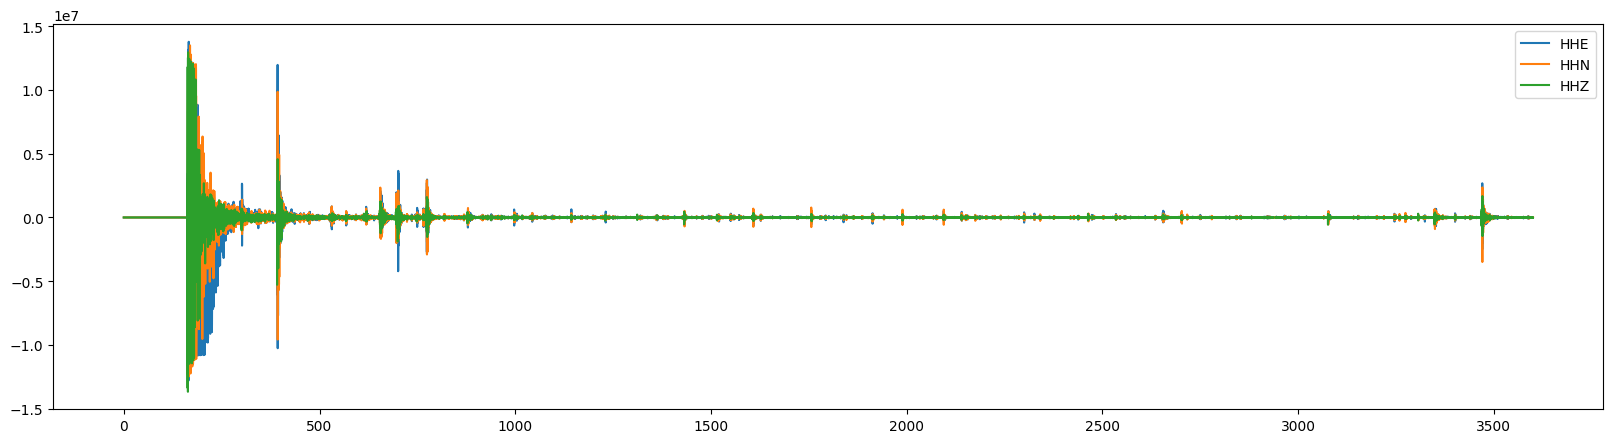

In [8]:
# Reading & Plotting Real Seismic Data (L’Aquila Earthquake)
from obspy.clients.fdsn import Client       # FDSN client to get waveforms
from obspy import UTCDateTime               # For timestamp handling
import matplotlib.pyplot as plt             # For plotting
import obspy as obs                         # Full obspy usage
import numpy as np

client = Client("INGV")                     # INGV = Italian seismic data provider

t = UTCDateTime(2009, 4, 6, 1, 30)          # Start time of recording (UTC)

stream = client.get_waveforms(              # Request waveform data:
    network="MN",                           # Seismic network
    station="AQU",                          # Station code
    location="*",                           # Accept any location code
    channel="HH?",                          # High-gain channels (HHE, HHN, HHZ)
    starttime=t,                            # Start ~1:30 AM
    endtime=t+3600                          # 1-hour recording
)


# Plot the Waveform
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();

#  Putput plots all three components:(Blue = HHE, Orange = HHN, Green = HHZ)
# The mainshock appears as a high-amplitude spike on all channels early in the trace.
# Small bumps later are aftershocks or background tremors.

#### Predict model on seismic stream

We can apply our varying models now to the seismic stream through the high level ```annotate``` method. This will output the charactersitic functions for the probability of a P-phase, S-phase, and noise class respectively.

In [17]:
#  model prediction step  using annotate where the pretrained neural networks analyze your seismic waveform and return their predictions.
pn_preds = pn_model.annotate(stream)     # PhaseNet: predicts P, S, and noise probabilities
eqt_preds = eqt_model.annotate(stream)   # EQTransformer: same but from a more complex model
gpd_preds = gpd_model.annotate(stream)   # GPD: predicts noise probability (for denoising)

pn_preds                                 # Output the PhaseNet prediction traces


# The output processed the 3-component waveform at 100 Hz, over a ~1 hour span (~359,500 samples) and give the Probability of P-s waves and noise

3 Trace(s) in Stream:
MN.AQU..PhaseNet_P | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples
MN.AQU..PhaseNet_S | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples
MN.AQU..PhaseNet_N | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples

#### Step through to 'zoom in' on predictions

Enter window length in seconds, and define which model predictions you would like to plot

In [12]:
# Set Zoom Window for Plots
wlength = 5 * 60            # Duration of the window to display in seconds (5 minutes)

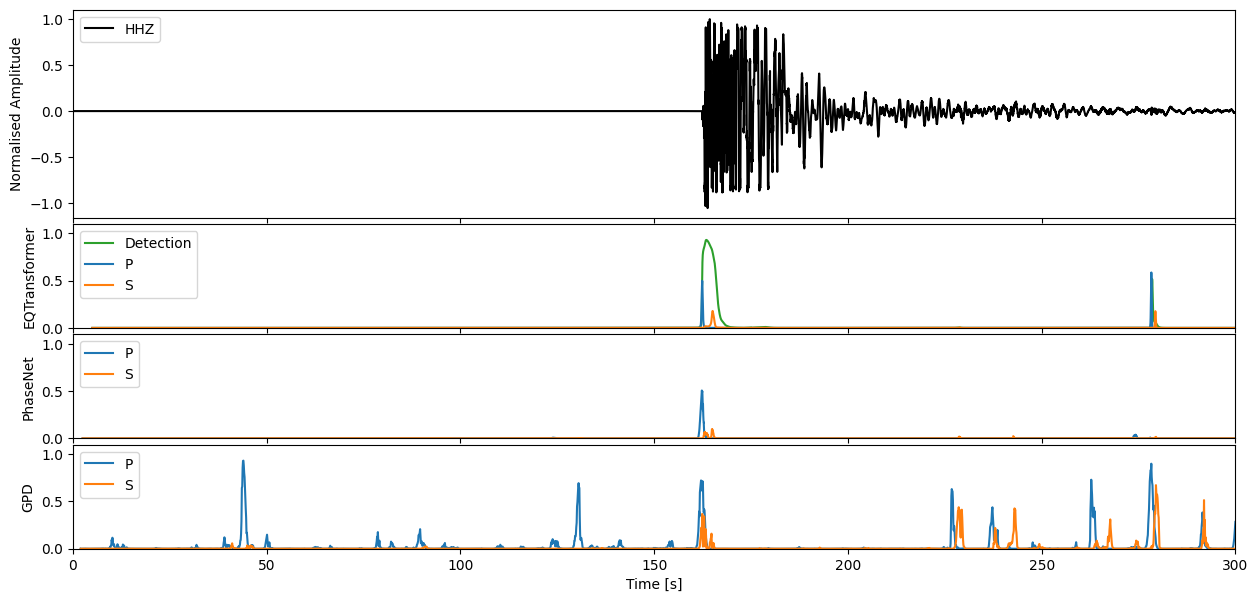

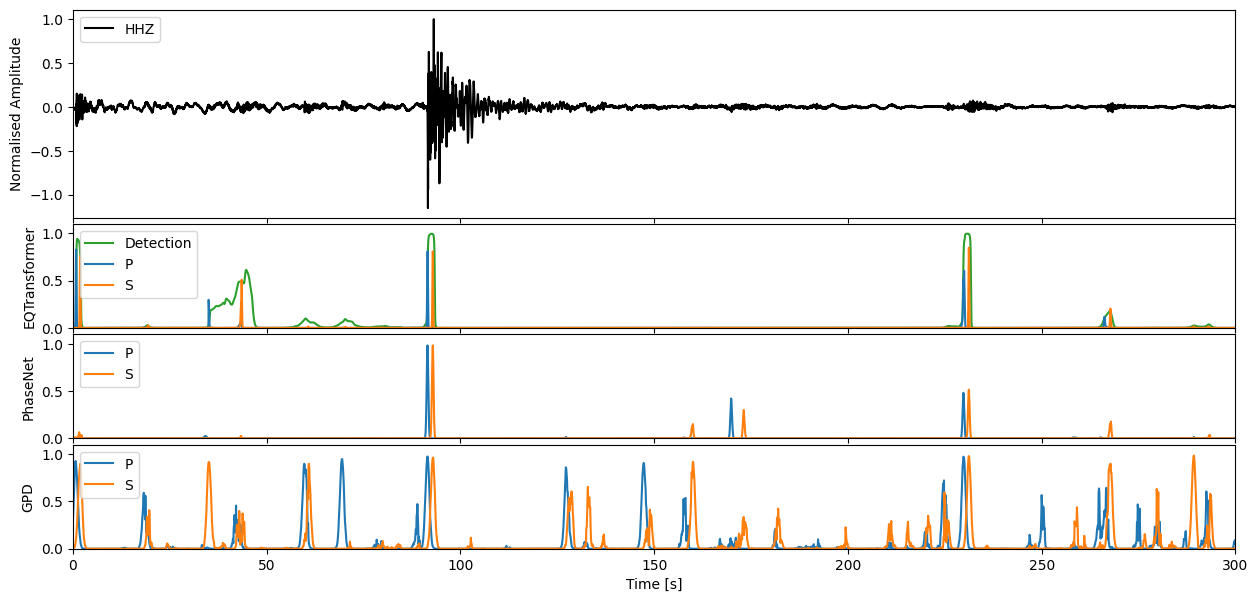

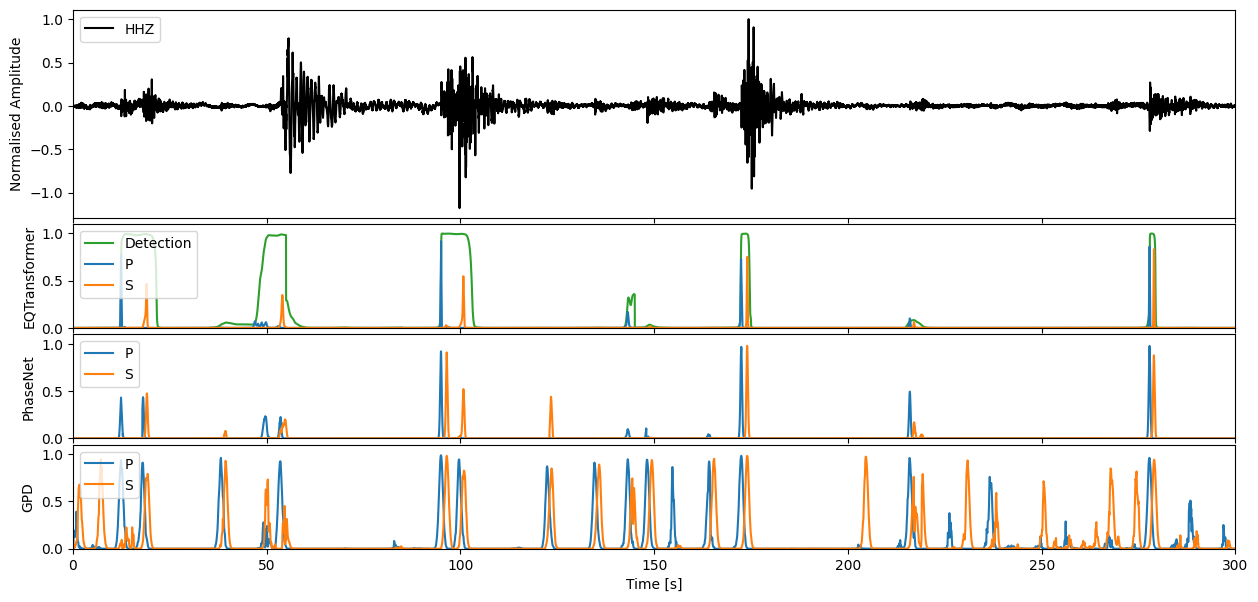

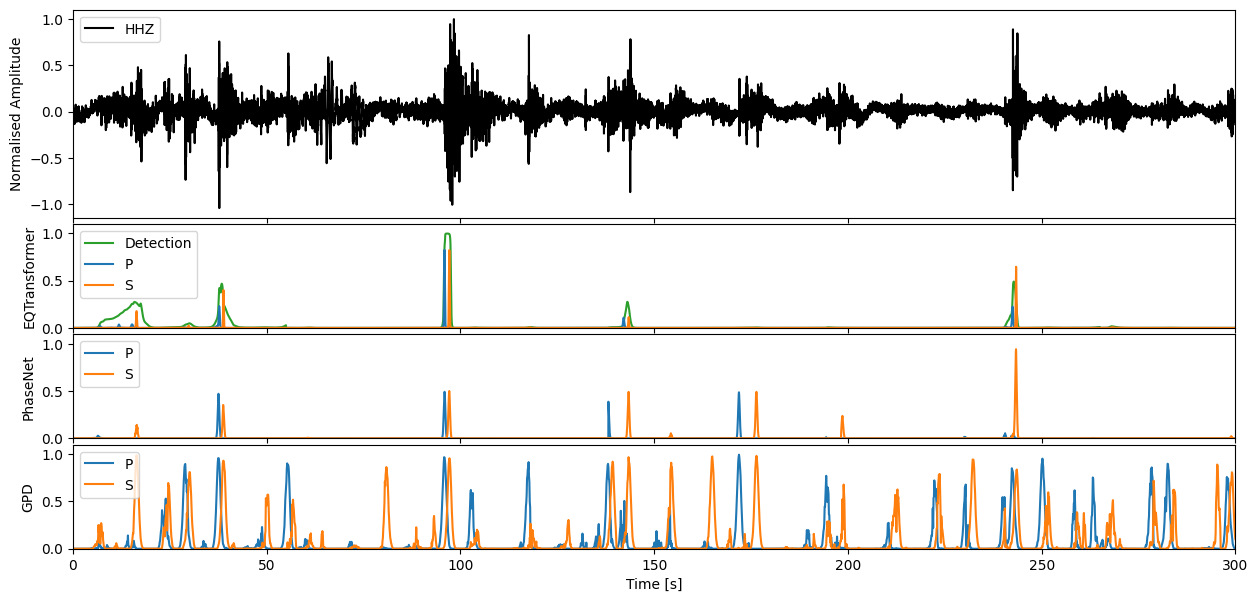

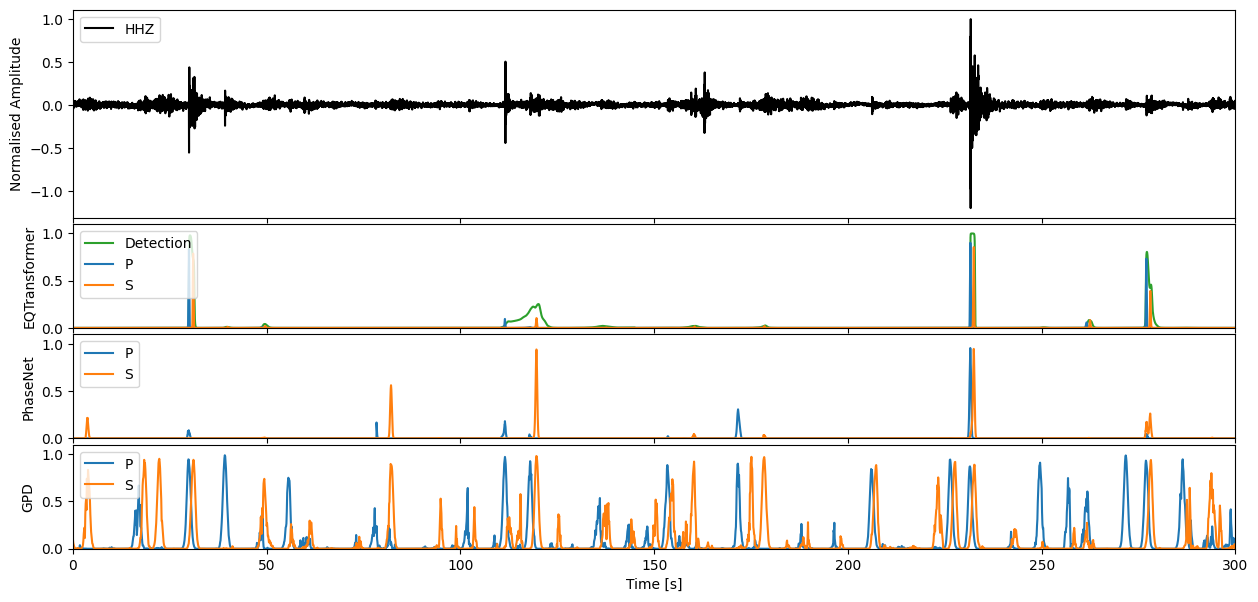

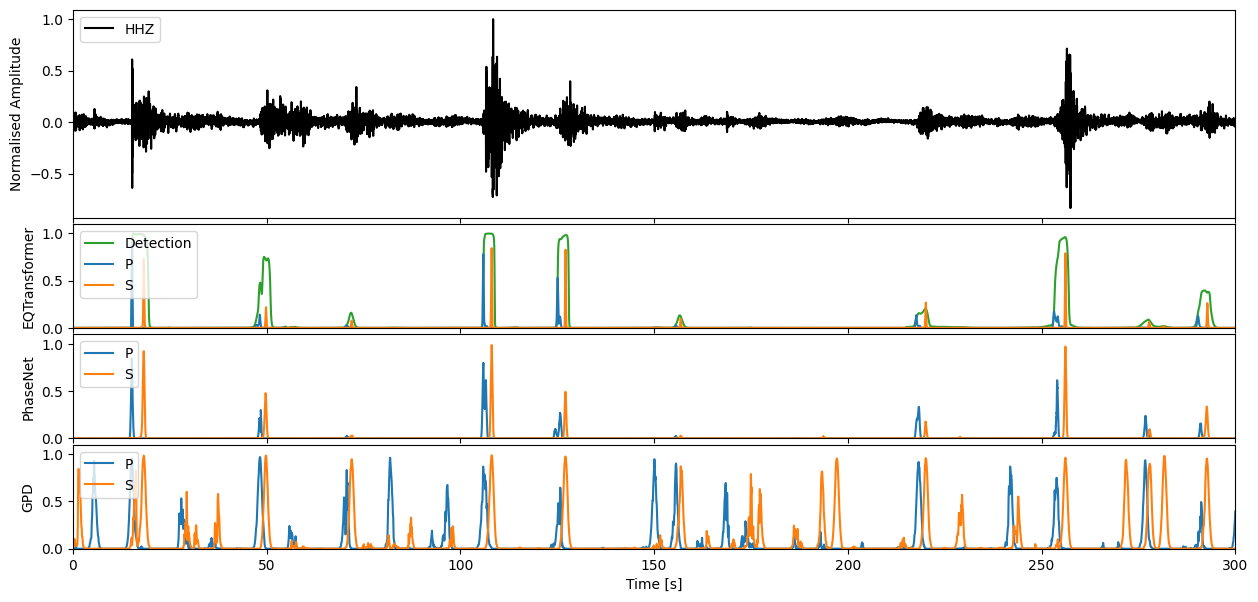

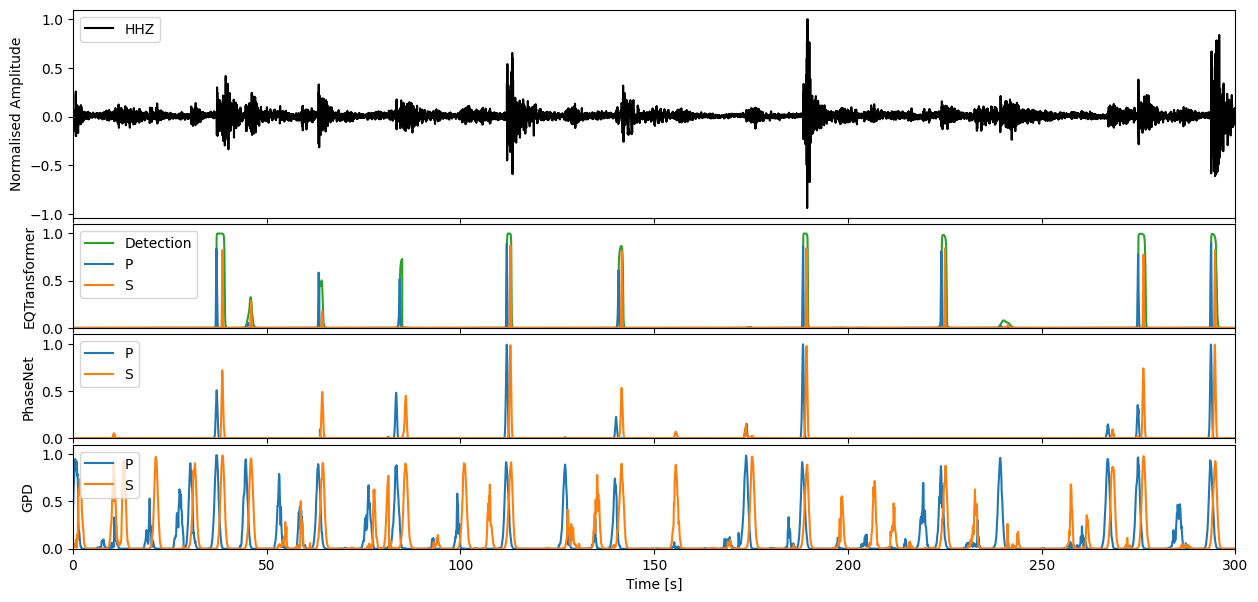

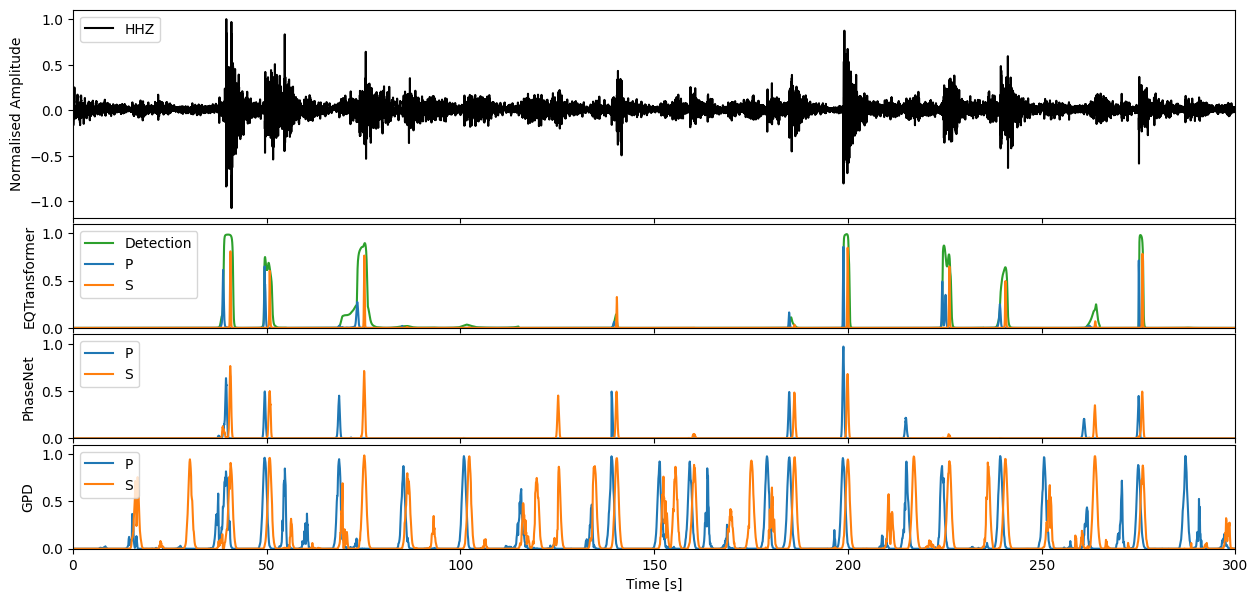

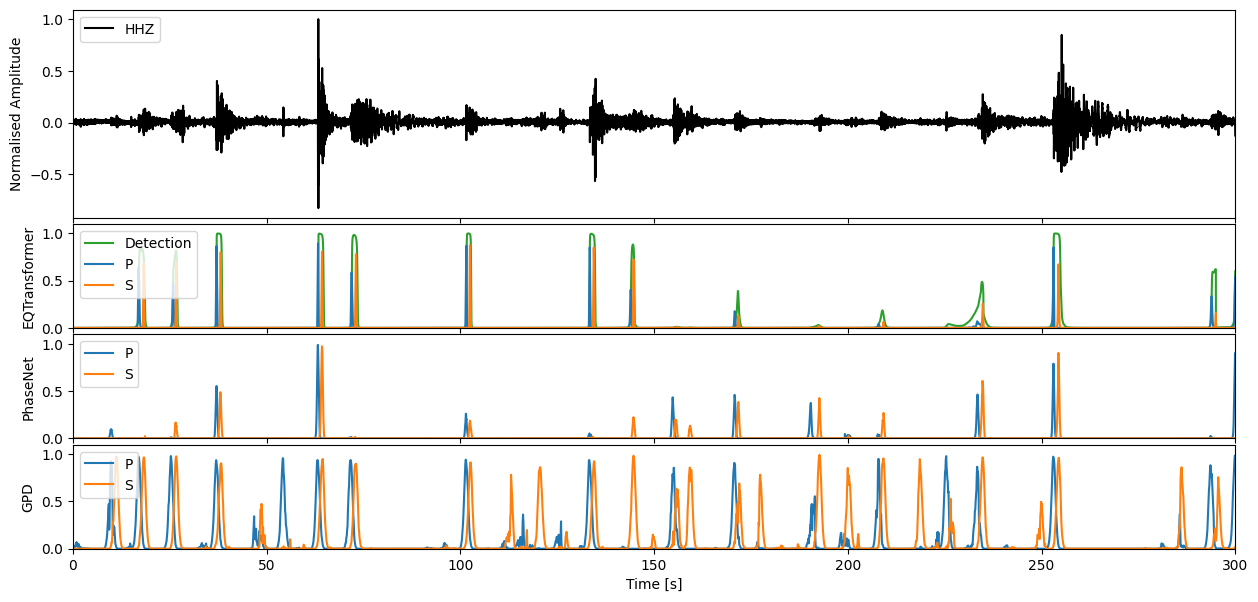

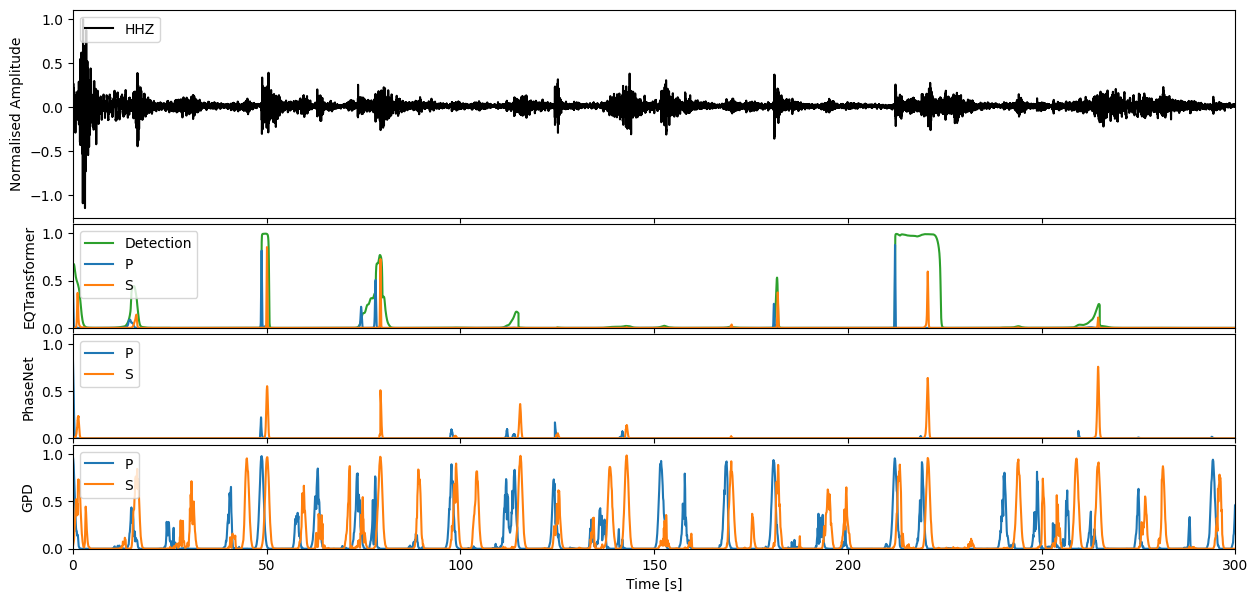

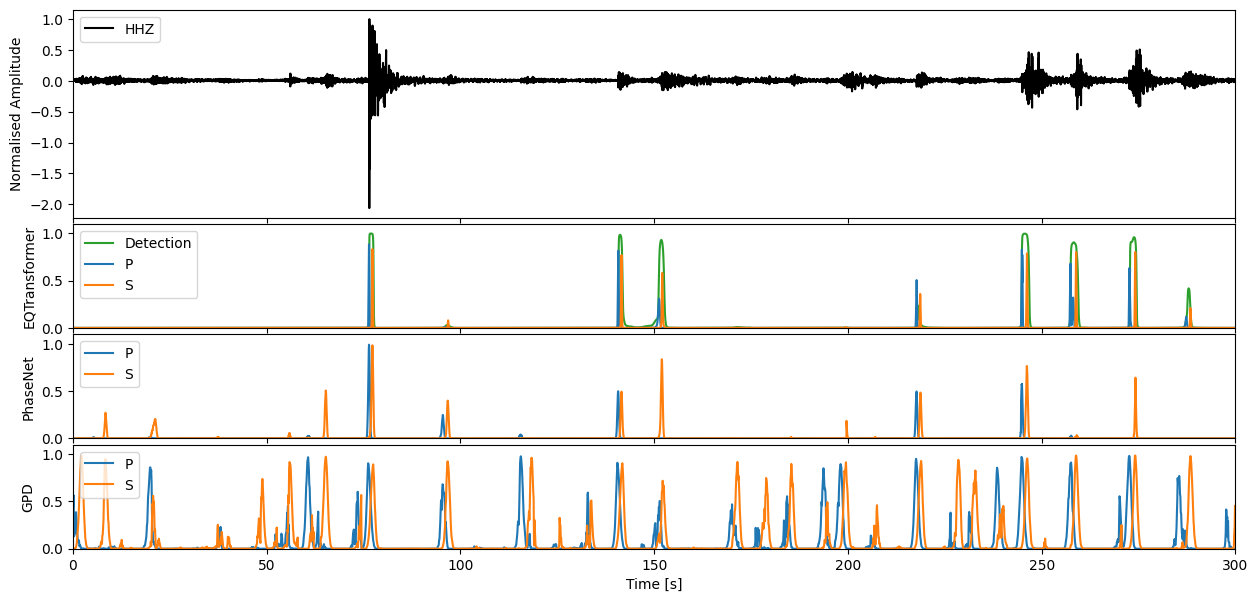

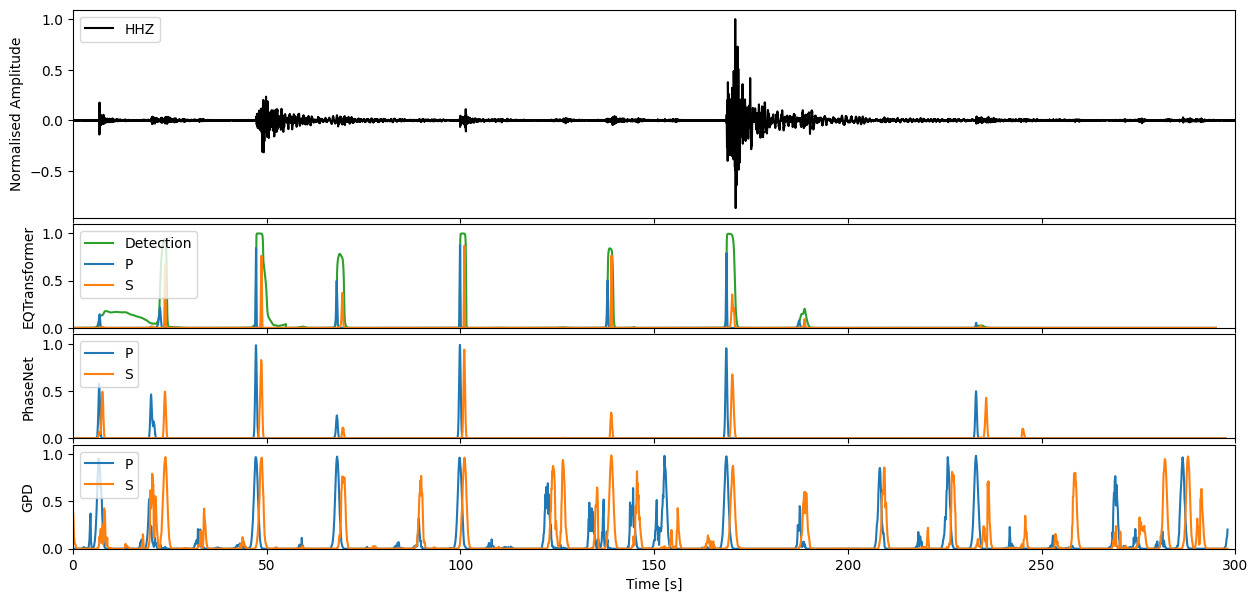

In [18]:
# Zoomed Multi-model Prediction Plot

# Define color mapping for classes
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

# Loop through the entire stream in 5-minute segments (wlength in seconds)
for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s  # Start time of the current segment
    t1 = t0 + wlength                   # End time of the current segment
    subst = stream.slice(t0, t1)       # Slice the original waveform for this segment

    # Create 4 vertically stacked plots: waveform + 3 model outputs
    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True,
                           gridspec_kw={'hspace': 0.05, 'height_ratios': [2, 1, 1, 1]})

    # Loop through each prediction set: EQTransformer, PhaseNet, GPD
    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)  # Slice predictions to match the current 5-min segment
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime  # Time alignment

        # Loop through each prediction trace (e.g., P, S, Noise)
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")  # Get model and class name (e.g., PhaseNet_P)

            if pred_class == "N":
                # Skip noise class predictions (we don't plot them)
                continue

            c = color_dict[pred_class]  # Select color based on class (P/S/Detection)
            # Plot prediction curve (e.g., probability trace of P or S) with offset time
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)

        # Label Y-axis with model name (e.g., EQTransformer)
        ax[i + 1].set_ylabel(model)
        # Add legend for P/S color labels
        ax[i + 1].legend(loc=2)
        # Fix y-axis between 0 and 1.1 for all probability plots
        ax[i + 1].set_ylim(0, 1.1)

    # Plot the seismic waveform (normalized) in the top panel
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data),
               'k', label=subst[-1].stats.channel)

    ax[0].set_xlim(0, wlength)           # Set x-axis range (0 to 300 seconds)
    ax[0].set_ylabel('Normalised Amplitude')  # Y-axis label
    ax[3].set_xlabel('Time [s]')         # Bottom x-axis label for the whole plot
    ax[0].legend(loc=2)                  # Add channel name (e.g., HHZ) to legend

    # Show the complete figure for this segment
    plt.show()

# Top Panel – Waveform: Shows the vertical channel (HHZ) of seismic motion and Black spikes = arrivals (mainshock, aftershocks).

# Panel 2 – EQTransformer:Green: General detection, Blue: P-wave probability, Orange: S-wave probability, Often has smoother curves, sometimes broader detection zones.

# Panel 3 – PhaseNet:Focused and spiky predictions.Captures distinct P/S arrivals sharply.Can show multiple events clearly.

#  Panel 4 – GPD (Denoising Probabilities):Uses similar P/S structure, but often noisier and less reliable.Useful for checking detection sensitivity, not high preci

If you would like to then make deterministic detections from the continuous characteristic functions, the ```classify``` method of each model will allow you to perform this task.

In [24]:
# Run PhaseNet model to produce final P and S picks (not probabilities)
# Output is a structured list of pick objects with phase label, timestamp, confidence, etc.
outputs = pn_model.classify(stream)

In [25]:
# Print a human-readable summary of the results:
# Lists the number of picks and their type (P or S) and time
print(outputs)

# Output is Each line = 1 pick, with:(Network.Station,Timestamp,Phase label (P or S)

ClassifyOutput(creator='PhaseNet', picks=PickList with 122 entries:

MN.AQU.	2009-04-06T01:32:42.308597Z	P
MN.AQU.	2009-04-06T01:36:31.508597Z	P
MN.AQU.	2009-04-06T01:36:32.868597Z	S
...
MN.AQU.	2009-04-06T02:27:50.218597Z	S
MN.AQU.	2009-04-06T02:28:53.088597Z	P
MN.AQU.	2009-04-06T02:28:55.708597Z	S)


With each pick storing the following information:

In [23]:
# Print all internal information stored in the first pick
# Accesses it as a dictionary to view all metadata fields
print(outputs.picks[0].__dict__)

# Output is precise metadata for each individual pick.
# Each pick has: (A phase label (P/S), A peak_time (timestamp of arrival), A confidence score (peak_value))

{'trace_id': 'MN.AQU.', 'start_time': UTCDateTime(2009, 4, 6, 1, 32, 41, 938597), 'end_time': UTCDateTime(2009, 4, 6, 1, 32, 42, 828597), 'peak_time': UTCDateTime(2009, 4, 6, 1, 32, 42, 308597), 'peak_value': np.float32(0.506276), 'phase': 'P'}
